# Estimating Detector Resolution
This notebook describes how we determine the detector resolution by calculating the difference between the simulated true momenta and just simulated momenta. It is expected that these results should be consistent with those in the LHCb detector paper given at the start of the project.

## Getting the Data
The first step to achieving the above is to import the data from the ROOT file and extract the variables we need into a Pandas dataframe. Using Pandas over numpy is a somewhat arbitrary choice though mostly due to ease-of-use and familiarity. Note here we are doing the momentum not the position resolution.

In [1]:
import uproot as up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fName="/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/100FilesCheck/job185-CombDVntuple-15314000-MC2016MD_100F-pKmue-MC.root"

In [2]:
with up.open(fName + ":DTT1520me/DecayTree") as f:
    df = f.arrays(["L1_PX", "L1_TRUEP_X", "L1_PY", "L1_TRUEP_Y", "L1_TRUEP_Z", "L1_PZ", "L1_TRUEPT", "L1_PT"], library="pd")
    df.columns = ['Px', 'TPx', 'Py', 'TPy', 'Pz', 'TPz', 'TPT', 'PT']
    # Drop the duplictaes since about 30% of the data is duplicated
    df.drop_duplicates(keep='first', inplace=True)
df.head()

,Px,TPx,Py,TPy,Pz,TPz,TPT,PT
0,2191.14,2197.44,398.49,396.74,11115.96,11076.01,2232.967797,2227.080775
8,3973.59,3976.55,922.88,925.05,37807.57,37791.28,4082.727937,4079.353501
10,-2335.96,-2344.85,1606.08,1615.40,55761.03,55554.07,2847.426677,2834.819586
11,-641.30,-639.89,-1200.30,-1186.90,30815.15,30694.31,1348.403064,1360.876842
13,-3110.08,-3115.87,-423.26,-413.89,16811.16,16864.15,3143.238901,3138.749215


## Feature Engineering
To better understand our data and extract some more useful plots we will do some feature engineering. That is using variables to create other variables of interest - in this case using the x, y, and z momentum so extract the transverse and total momentum. From these we can find the polar angle of the particle relative to the beam axis. That is $\sin\theta=\frac{p_T}{|p|}$.

In [3]:
df['P'] = np.sqrt(df['Px']**2 + df['Py']**2 + df['Pz']**2) # The magnitude of the measured total momentum
df['TP'] = np.sqrt(df['TPx']**2 + df['TPy']**2 + df['TPz']**2) # The magnitude of the true total momentum
df.head()

,Px,TPx,Py,TPy,Pz,TPz,TPT,PT,P,TP
0,2191.14,2197.44,398.49,396.74,11115.96,11076.01,2232.967797,2227.080775,11336.862683,11298.855814
8,3973.59,3976.55,922.88,925.05,37807.57,37791.28,4082.727937,4079.353501,38027.009799,38011.176139
10,-2335.96,-2344.85,1606.08,1615.40,55761.03,55554.07,2847.426677,2834.819586,55833.042804,55626.994636
11,-641.30,-639.89,-1200.30,-1186.90,30815.15,30694.31,1348.403064,1360.876842,30845.185286,30723.913442
13,-3110.08,-3115.87,-423.26,-413.89,16811.16,16864.15,3143.238901,3138.749215,17101.662117,17154.576824


Now we create the plots showing the angular distributions. We will keep everything in radians for now since this is what most of the LHCb papers use to quantify the angular resoltion of the detector. We can then find the resoution of the detector as a function of angle.

In [4]:
df['theta'] = np.arcsin(df['PT']/df['P']) # Theta here is measured in radians
df['T_theta'] = np.arcsin(df['TPT']/df['TP'])
df.head()

,Px,TPx,Py,TPy,Pz,TPz,TPT,PT,P,TP,theta,T_theta
0,2191.14,2197.44,398.49,396.74,11115.96,11076.01,2232.967797,2227.080775,11336.862683,11298.855814,0.197732,0.198937
8,3973.59,3976.55,922.88,925.05,37807.57,37791.28,4082.727937,4079.353501,38027.009799,38011.176139,0.107482,0.107616
10,-2335.96,-2344.85,1606.08,1615.40,55761.03,55554.07,2847.426677,2834.819586,55833.042804,55626.994636,0.050795,0.051210
11,-641.30,-639.89,-1200.30,-1186.90,30815.15,30694.31,1348.403064,1360.876842,30845.185286,30723.913442,0.044134,0.043902
13,-3110.08,-3115.87,-423.26,-413.89,16811.16,16864.15,3143.238901,3138.749215,17101.662117,17154.576824,0.184581,0.184271


Now let us plot these data as a function of angle. That is create a histogram of the angle of the particle relative to the beam axis in radians.

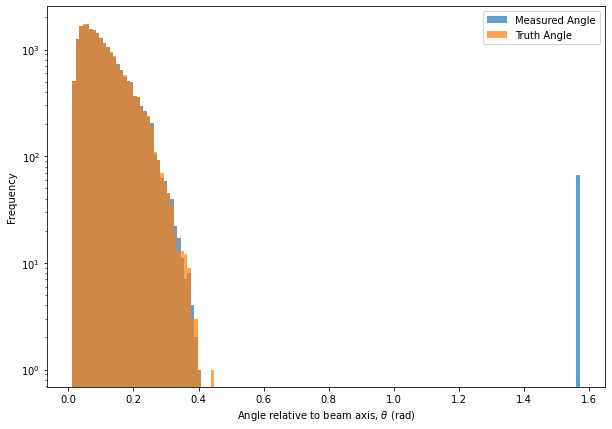

In [5]:
bins = 150
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
measured = ax.hist(df['theta'], bins=bins, label='Measured Angle', alpha=0.7)
true = ax.hist(df['T_theta'], bins=measured[1], label='Truth Angle', alpha=0.7) # Use the same sets of bins for all the data!
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'Angle relative to beam axis, $\theta$ (rad)')
plt.legend()
plt.show()

## Cleaning the Data
Before we can perform any calculations it is prudent to notice that these data are not perfect. For whatever reason the simulation has misbehaved and we have some strange results at angles exceeding $0.4$ rad. Let us split the data to remove these points and investigate them separately. Then we can calculate the resolution using only the "correct" data.

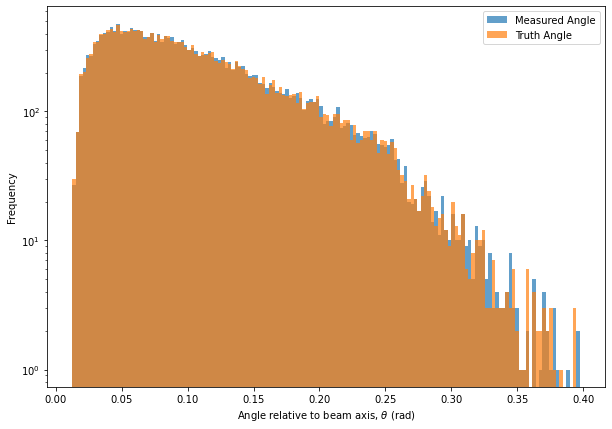

In [6]:
# Now remove all data from the dataframe where the measured angle is 'incorrect' i.e. greater than 0.4 rad
df = df.loc[(df['theta'] < 0.4)]
# Now plot these data

bins = 150
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
measured = ax.hist(df['theta'], bins=bins, label='Measured Angle', alpha=0.7)
true = ax.hist(df['T_theta'], bins=measured[1], label='Truth Angle', alpha=0.7) # Use the same sets of bins for all the data!
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'Angle relative to beam axis, $\theta$ (rad)')
plt.legend()
plt.show()

We now calculate the efficiency by considering the following, that the number of recorded events $\mathcal{N}$ is given by $\mathcal{N}=\frac{\mathcal{L}\sigma}{\epsilon}$ for $\epsilon$ the detector efficiency. Given our binwise data can calculate the efficiency as a function of angle to the beam axis, $\theta$. Essentially since we know $\mathcal{N_{true}}$ and $\mathcal{N_{measured}}$ we can calculate the efficiency as $\mathcal{N_{measured}}/\mathcal{N_{true}}=\epsilon$.

## Efficiency of Muon Detection versus Angle

In [7]:
edges = measured[1]
bin_middles = [(edges[i] + edges[i+1])/2 for i in range(len(edges)-1)]
# This is so we can do a scatter plot

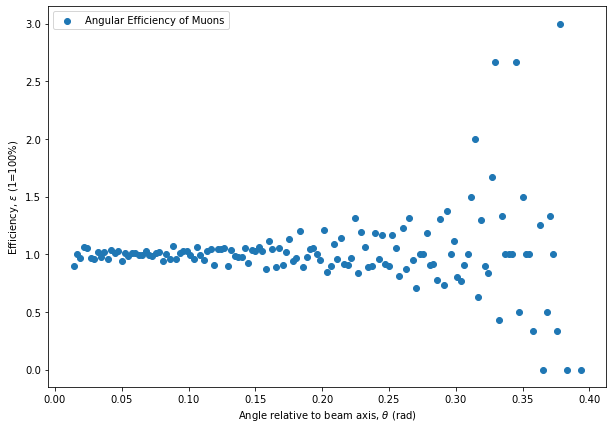

In [8]:
eff_df = pd.DataFrame({'Measured': measured[0], 'True': true[0], 'Bins': bin_middles})
eff_df = eff_df.loc[eff_df['True'] > 0]
eff = eff_df['Measured'] / eff_df['True']
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(eff_df['Bins'], eff, label='Angular Efficiency of Muons')
ax.set_ylabel(r'Efficiency, $\epsilon$ (1=100%)')
ax.set_xlabel(r'Angle relative to beam axis, $\theta$ (rad)')
plt.legend()
plt.show()

In [9]:
np.average(eff)

1.019706052850668

## Issues with Current Analysis
One of the biggest issues with these current analyses is that this includes 'all' the data. A better way to do this would be to select only signal events and see how the angular efficiency changes for these. As these data are simulated we are given a PID (Particle ID) for all the events. We can use the strict PID matching criteria to select pure signal and then see how our effiency changes.

In [10]:
with up.open(fName + ":DTT1520me/DecayTree") as f:
    df = f.arrays(["L1_PX", "L1_TRUEP_X", "L1_PY", "L1_TRUEP_Y", "L1_TRUEP_Z", "L1_PZ", "L1_TRUEPT", "L1_PT", "L1_TRUEID", "L1_ID"], library="pd")
    df.columns = ['Px', 'TPx', 'Py', 'TPy', 'Pz', 'TPz', 'TPT', 'PT', 'TID', 'ID']
    # Drop the duplictaes since about 30% of the data is duplicated
    df.drop_duplicates(keep='first', inplace=True)
    print(len(df))
df.head()

21843


,Px,TPx,Py,TPy,Pz,TPz,TPT,PT,TID,ID
0,2191.14,2197.44,398.49,396.74,11115.96,11076.01,2232.967797,2227.080775,13,13
8,3973.59,3976.55,922.88,925.05,37807.57,37791.28,4082.727937,4079.353501,13,13
10,-2335.96,-2344.85,1606.08,1615.40,55761.03,55554.07,2847.426677,2834.819586,13,13
11,-641.30,-639.89,-1200.30,-1186.90,30815.15,30694.31,1348.403064,1360.876842,13,13
13,-3110.08,-3115.87,-423.26,-413.89,16811.16,16864.15,3143.238901,3138.749215,13,13


In [11]:
df = df.loc[df['TID'] == df['ID']]
df['P'] = np.sqrt(df['Px']**2 + df['Py']**2 + df['Pz']**2) # The magnitude of the measured total momentum
df['TP'] = np.sqrt(df['TPx']**2 + df['TPy']**2 + df['TPz']**2) # The magnitude of the true total momentum
df['theta'] = np.arcsin(df['PT']/df['P']) # Theta here is measured in radians
df['T_theta'] = np.arcsin(df['TPT']/df['TP'])
df.head()

,Px,TPx,Py,TPy,Pz,TPz,TPT,PT,TID,ID,P,TP,theta,T_theta
0,2191.14,2197.44,398.49,396.74,11115.96,11076.01,2232.967797,2227.080775,13,13,11336.862683,11298.855814,0.197732,0.198937
8,3973.59,3976.55,922.88,925.05,37807.57,37791.28,4082.727937,4079.353501,13,13,38027.009799,38011.176139,0.107482,0.107616
10,-2335.96,-2344.85,1606.08,1615.40,55761.03,55554.07,2847.426677,2834.819586,13,13,55833.042804,55626.994636,0.050795,0.051210
11,-641.30,-639.89,-1200.30,-1186.90,30815.15,30694.31,1348.403064,1360.876842,13,13,30845.185286,30723.913442,0.044134,0.043902
13,-3110.08,-3115.87,-423.26,-413.89,16811.16,16864.15,3143.238901,3138.749215,13,13,17101.662117,17154.576824,0.184581,0.184271


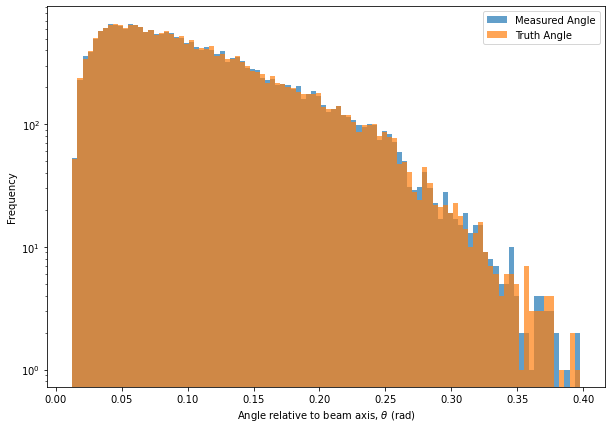

In [12]:
bins = 100
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
measured = ax.hist(df['theta'], bins=bins, label='Measured Angle', alpha=0.7)
true = ax.hist(df['T_theta'], bins=measured[1], label='Truth Angle', alpha=0.7) # Use the same sets of bins for all the data!
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'Angle relative to beam axis, $\theta$ (rad)')
plt.legend()
plt.show()

Interestingly when we used the strict PID matching no events were observed at an angle of more than $0.4$ rad relative to the beam axis. The efficiency looks broadly the same as well (see plots below).

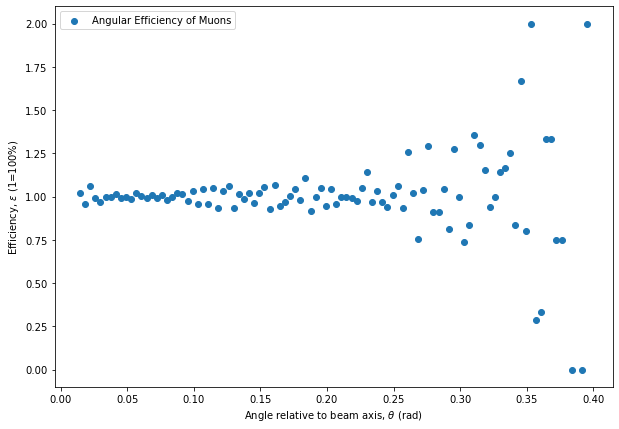

In [13]:
edges = measured[1]
bin_middles = [(edges[i] + edges[i+1])/2 for i in range(len(edges)-1)]
# This is so we can do a scatter plot
eff_df = pd.DataFrame({'Measured': measured[0], 'True': true[0], 'Bins': bin_middles})
eff_df = eff_df.loc[eff_df['True'] > 0]
eff = eff_df['Measured'] / eff_df['True']
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(eff_df['Bins'], eff, label='Angular Efficiency of Muons')
ax.set_ylabel(r'Efficiency, $\epsilon$ (1=100%)')
ax.set_xlabel(r'Angle relative to beam axis, $\theta$ (rad)')
plt.legend()
plt.show()

In [14]:
np.average(eff)

1.0036392850158462

## Resolution as a Function of Angle
We have found the efficiency as a function of angle - now we find the resolution as a function of angle which is defined as,
$\delta(\theta)=\theta_{measured}-\theta_{true}\equiv\theta-\hat{\theta}$. We wish to do this by looking inside each bin and asking the above question and plotting a distribution of these data (it should be Gaussian) from this we can extract a mean resolution and error on this value for each bin. Then we can plot this distribution!

In [15]:
def get_angular_resolution(particle, bins=150, truth_matching=False):
    """
    Paramters:
        particle (str): The type of particle to be investigated. Allowed types are 'p' (proton), 'k' (kaon), 'L1' (muon) and 'L2' (electron)
        bins (int): The number of bins to divide the data through. Higher number of bins lead to greater cross-bin leakage. Default is 150. 
        truth_matching (bool): Remove all events which are not explicitly signal events by matching particle ID's. Default is False.
    Returns:
        resolution (array): A numpy array of resolution and associated errors. Such that array[0] yields [x, y, xerr, yerr] for the first angle bin
    """
    with up.open(fName + ":DTT1520me/DecayTree") as f:
        features = ["_PX", "_TRUEP_X", "_PY", "_TRUEP_Y", "_TRUEP_Z", "_PZ", "_TRUEPT", "_PT", "_TRUEID", "_ID"]
        features = [particle + i for i in features]
        df = f.arrays(features, library="pd")
    df.columns = ['Px', 'TPx', 'Py', 'TPy', 'Pz', 'TPz', 'TPT', 'PT', 'TID', 'ID']
    df.drop_duplicates(keep='first', inplace=True)
    df['theta'] = np.arcsin(df['PT']/np.sqrt(df['Px']**2 + df['Py']**2 + df['Pz']**2))
    df['Ttheta'] = np.arcsin(df['TPT']/np.sqrt(df['TPx']**2 + df['TPy']**2 + df['TPz']**2))
    df['dtheta'] = df['theta'] - df['Ttheta']
    df = df[['theta', 'Ttheta', 'dtheta']]
    print(df.head())
    return 1
    
get_angular_resolution('L2')

       theta    Ttheta    dtheta
0   0.096312  0.096527 -0.000215
1   0.120042  0.121073 -0.001031
8   0.082308  0.108738 -0.026430
10  0.072180  0.071269  0.000911
11  0.101249  0.102767 -0.001517


1

In [16]:
a = df.copy() # Recall df has duplicate events and events where TRUEID != ID removed
a = a[['theta', 'T_theta']]
a['dtheta'] = a['theta'] - a['T_theta']
bin_edges = measured[1] # We have the edges of all the bins here now use Pandas groupby to collect into interval bins
a = a.loc[(a['theta'] < max(bin_edges)) & (a['theta'] > min(bin_edges))]
a.describe()

,theta,T_theta,dtheta
count,21631.000000,21631.000000,21631.000000
mean,0.106365,0.106286,0.000079
std,0.064373,0.064353,0.002034
min,0.012640,0.012746,-0.134563
25%,0.055940,0.055755,-0.000418
50%,0.091914,0.091770,0.000079
75%,0.143271,0.143145,0.000606
max,0.395127,0.403160,0.112787


In [17]:
def GroupRowFunc(df, col='theta'):
    bin_nums = []
    for row in df.iterrows():
        value = row[1].loc[col]
        bin_num = [n for n, i in enumerate(bin_edges) if i < value][-1]
        bin_nums.append(bin_num)
    return bin_nums

b = GroupRowFunc(a)
a['bin'] = b
a.head()

,theta,T_theta,dtheta,bin
0,0.197732,0.198937,-0.001205,48
8,0.107482,0.107616,-0.000134,24
10,0.050795,0.051210,-0.000415,9
11,0.044134,0.043902,0.000232,8
13,0.184581,0.184271,0.000310,44


In [18]:
grouped_angles = a.groupby(['bin'])
means = grouped_angles.mean()['dtheta'].to_numpy() # The mean of the resolution in each bin
std = grouped_angles.agg(np.std, ddof=0)['dtheta'].to_numpy() # The standard devitation of the resolution within each bin

In [30]:
data = {}
for bin_number, group in grouped_angles:
    data[bin_number] = plt.hist(group['dtheta'], bins=50)
    print(data[bin_number][1])
    data[bin_number] = (data[bin_number][0], [(data[bin_number][1][i] + data[bin_number][1][i+1])/2 for i in range(len(data[bin_number][1]) - 1)])
    plt.close() # Prevent the plots from being rendered, speeds up runtime by ~30%

[-4.90490546e-04 -4.69036993e-04 -4.47583440e-04 -4.26129887e-04
 -4.04676334e-04 -3.83222782e-04 -3.61769229e-04 -3.40315676e-04
 -3.18862123e-04 -2.97408571e-04 -2.75955018e-04 -2.54501465e-04
 -2.33047912e-04 -2.11594359e-04 -1.90140807e-04 -1.68687254e-04
 -1.47233701e-04 -1.25780148e-04 -1.04326595e-04 -8.28730427e-05
 -6.14194899e-05 -3.99659371e-05 -1.85123844e-05  2.94116843e-06
  2.43947212e-05  4.58482740e-05  6.73018268e-05  8.87553796e-05
  1.10208932e-04  1.31662485e-04  1.53116038e-04  1.74569591e-04
  1.96023143e-04  2.17476696e-04  2.38930249e-04  2.60383802e-04
  2.81837355e-04  3.03290907e-04  3.24744460e-04  3.46198013e-04
  3.67651566e-04  3.89105118e-04  4.10558671e-04  4.32012224e-04
  4.53465777e-04  4.74919330e-04  4.96372882e-04  5.17826435e-04
  5.39279988e-04  5.60733541e-04  5.82187094e-04]
[-8.80712061e-04 -8.42967350e-04 -8.05222638e-04 -7.67477927e-04
 -7.29733216e-04 -6.91988505e-04 -6.54243794e-04 -6.16499083e-04
 -5.78754371e-04 -5.41009660e-04 -5.0326

In [27]:
all_bin_centres = [np.mean(data[i][1]) for i in list(data.keys())]
data[10][1]

[-0.002754851892711797,
 -0.0026322701834010677,
 -0.0025096884740903377,
 -0.0023871067647796085,
 -0.002264525055468879,
 -0.0021419433461581493,
 -0.00201936163684742,
 -0.0018967799275366904,
 -0.0017741982182259608,
 -0.0016516165089152312,
 -0.0015290347996045018,
 -0.0014064530902937722,
 -0.0012838713809830427,
 -0.001161289671672313,
 -0.0010387079623615837,
 -0.0009161262530508541,
 -0.0007935445437401245,
 -0.0006709628344293949,
 -0.0005483811251186653,
 -0.00042579941580793575,
 -0.0003032177064972064,
 -0.000180635997186477,
 -5.805428787574742e-05,
 6.452742143498217e-05,
 0.00018710913074571176,
 0.00030969084005644134,
 0.00043227254936717093,
 0.0005548542586779003,
 0.0006774359679886297,
 0.0008000176772993593,
 0.0009225993866100889,
 0.0010451810959208184,
 0.0011677628052315478,
 0.0012903445145422774,
 0.001412926223853007,
 0.0015355079331637366,
 0.0016580896424744662,
 0.0017806713517851958,
 0.0019032530610959253,
 0.002025834770406655,
 0.002148416479717384

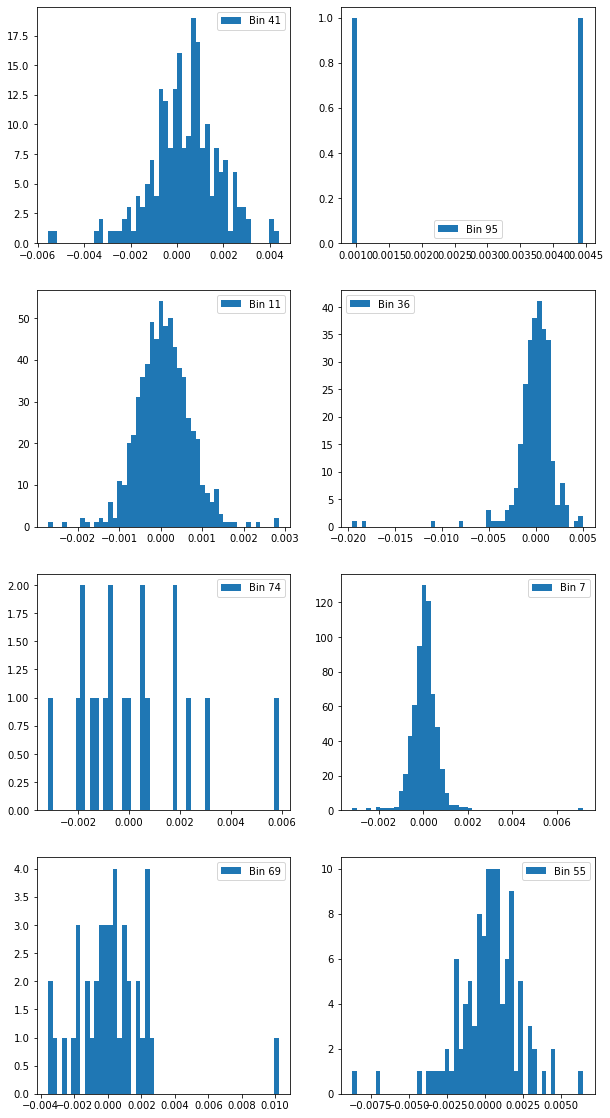

In [21]:
# Plot each set of points within a bin as a histogram instead as this is what is required
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
np.random.seed = 0 # Set the seed for the generator for consistency

random_bins = np.random.randint(0, 99, 8)
i = 0
for n in range(4):
    for m in range(2):
        random_bin = random_bins[i]
        j = grouped_angles.get_group(random_bin)['T_theta']
        ax[n,m].hist(grouped_angles.get_group(random_bin)['dtheta'], label=f'Bin {random_bin}', bins=50)
        ax[n,m].legend()
        i += 1
    
plt.legend()
plt.show()

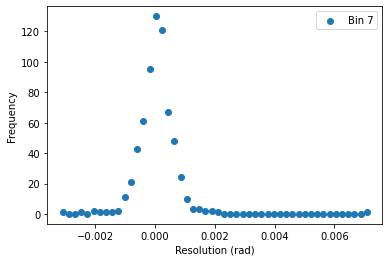

In [22]:
# Plot some of these histograms for randomly selected bins (as a scatter plot)
num = 7
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(data[num][1], data[num][0], label=f'Bin {num}')
ax.set_ylabel('Frequency')
ax.set_xlabel('Resolution (rad)')
plt.legend()
plt.show()

In [23]:
# Use `means` from before
from scipy.optimize import curve_fit

def normal(x, A, mu, std):
    return (A/np.sqrt(2*np.pi*(std**2))) * np.exp(-((x-mu)**2)/(2*(std**2)))

i = 0
popts = []
for bin_number, group in grouped_angles:
    if len(group['dtheta']) > 10:
        try:
            popt, pcov = curve_fit(normal, data[bin_number][1], data[bin_number][0], p0=[1, np.mean(group['dtheta']), 1e-3])
            popts.append(popt)
        except:
            print(f'Failed to find optimal parameters for bin {bin_number}')
            popts.append([1, np.mean(group['dtheta']), 0])
    else:
        # Do not try and fit a curve to anything with less than 10 points else it will be dreadful
        popts.append([1, np.mean(group['dtheta']), 0])
    i += 1

Failed to find optimal parameters for bin 75


## Finding Resolution as a Function of Polar Angle to Beam Axis
Now we have iterated through each bin and taken every point and determined its distance from the corresponding true value. Then within each bin collated all these measurements and found a mean and population standard deviation. We now plot these to see how the resolution changes as a fucntion of angle.

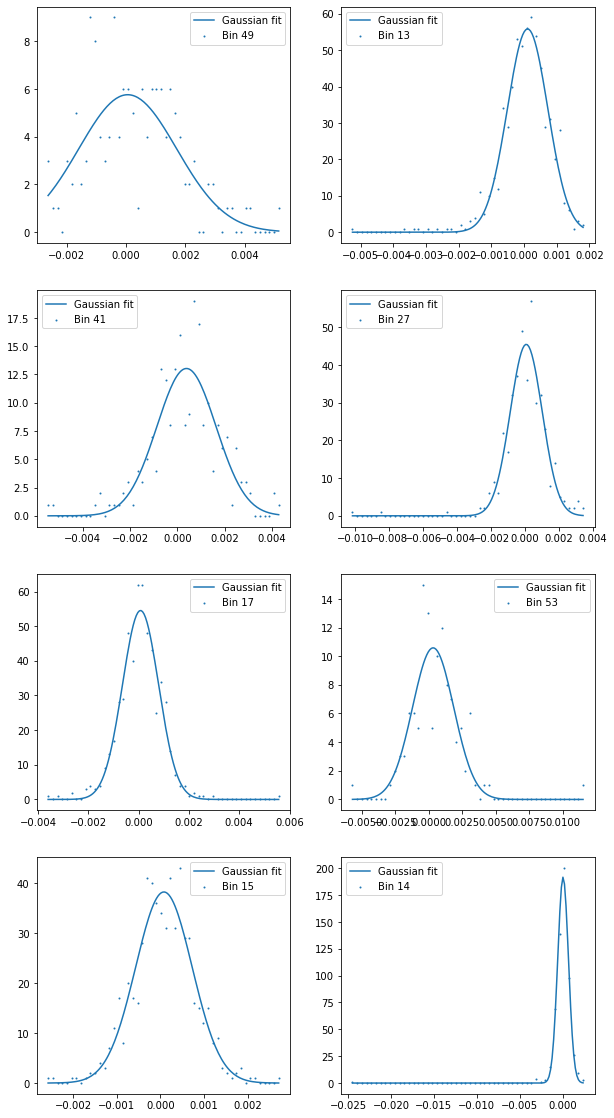

In [24]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
np.random.seed = 5 # Set the seed for the generator for consistency

random_bins = np.random.randint(0, 99, 8)
i = 0
for n in range(4):
    for m in range(2):
        random_bin = random_bins[i]
        j = data[random_bin][1]
        default_x = np.linspace(min(j), max(j), num=150)
        # i is the randomly generated bin number so let us plot the Gaussian first
        ax[n,m].plot(default_x, normal(default_x, *popts[random_bin]), label='Gaussian fit')
        ax[n,m].scatter(j, data[random_bin][0], s=1, label=f'Bin {random_bin}')
        ax[n,m].legend()
        i += 1
    
plt.legend()
plt.show()

In [25]:
means = [popts[i][1] for i in range(len(popts))]
stds = [popts[i][2] for i in range(len(popts))]

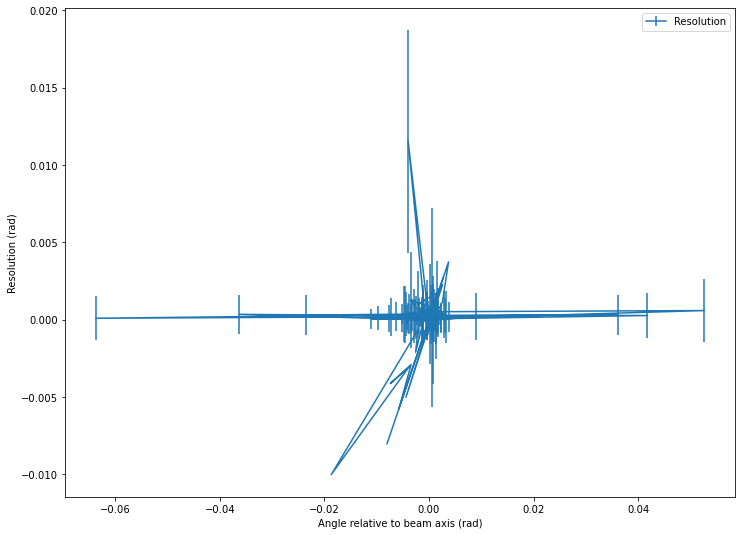

In [26]:
### ALL BIN CENTRES HAS AN ISSUE !!! #####

# Now plot the reslution for the muon using the fit parameters we found...
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.errorbar(all_bin_centres, means, xerr=None, yerr=stds, label='Resolution') # the 98 bins as the x-coord and the mean + std-dev from gaussian fit paramters
ax.set_ylabel('Resolution (rad)')
ax.set_xlabel('Angle relative to beam axis (rad)')
plt.legend()
plt.show()